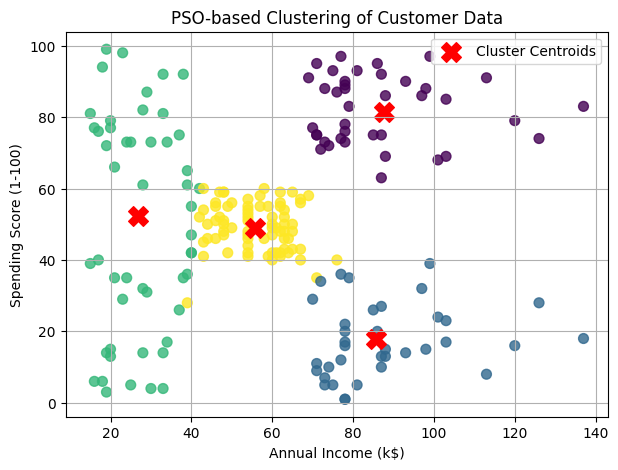

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the synthetic dataset
df = pd.read_csv("SCOA_A7.csv")

# Select features for clustering: Annual Income (k$) and Spending Score (1-100)
customer_data = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

# PSO parameters
num_particles = 30
num_iterations = 100
num_clusters = 4 # You might want to adjust this based on the dataset
w = 0.5       # inertia weight
c1 = 1.5      # cognitive coefficient
c2 = 1.5      # social coefficient

# Initialize particles
class Particle:
    def __init__(self, data, num_clusters):
        self.data = data
        self.num_clusters = num_clusters
        # Initialize position as float to avoid UFuncTypeError during update
        self.position = data[np.random.choice(range(len(data)), num_clusters, replace=False)].astype(float)
        self.velocity = np.zeros_like(self.position)
        self.best_position = np.copy(self.position)
        self.best_score = self.evaluate()

    def evaluate(self):
        distances = np.linalg.norm(self.data[:, None] - self.position[None, :], axis=2)
        closest = np.argmin(distances, axis=1)
        score = sum(np.linalg.norm(self.data[i] - self.position[closest[i]])**2 for i in range(len(self.data)))
        return score

    def update(self, global_best):
        r1, r2 = np.random.rand(), np.random.rand()
        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best - self.position)
        self.velocity = w * self.velocity + cognitive + social
        self.position += self.velocity
        score = self.evaluate()
        if score < self.best_score:
            self.best_score = score
            self.best_position = np.copy(self.position)

# Initialize swarm
swarm = [Particle(customer_data, num_clusters) for _ in range(num_particles)]
global_best = min(swarm, key=lambda p: p.best_score).best_position

# PSO loop
for _ in range(num_iterations):
    for particle in swarm:
        particle.update(global_best)
    global_best = min(swarm, key=lambda p: p.best_score).best_position

# Final clustering
distances = np.linalg.norm(customer_data[:, None] - global_best[None, :], axis=2)
labels = np.argmin(distances, axis=1)

# Plot results
plt.figure(figsize=(7, 5))
plt.scatter(customer_data[:, 0], customer_data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.scatter(global_best[:, 0], global_best[:, 1], c='red', marker='X', s=200, label='Cluster Centroids')
plt.title("PSO-based Clustering of Customer Data")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
'''
Velocity Update Equation:
V[]=V[]+c1*rand()*(pbest[]-present[])+c2*rand[]*(gbest[]-present[])
where c1 and c2 are learning factors, usually c1=c2=2
rand() and rand[] are random numbers in the range [0,1]
update particle position:
present[]=present[]+V[]'''

'''Code Explanation
Nice — I’ll walk through your script line-by-line in plain, simple language and add small notes where something could surprise you or be improved. I’ll follow the same order as your code and explain each block.

---

# Top-level imports & data

```python
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
```

* `numpy` (`np`): for numeric operations (arrays, math).
* `matplotlib.pyplot` (`plt`): for plotting the results.
* `pandas` (`pd`): for reading and handling the CSV file as a table.

```python
# Load the synthetic dataset
df = pd.read_csv("SCOA_A7.csv")
```

* Reads the CSV file `"SCOA_A7.csv"` into a pandas DataFrame named `df`.

```python
# Select features for clustering: Annual Income (k$) and Spending Score (1-100)
customer_data = df[['Annual Income (k$)', 'Spending Score (1-100)']].values
```

* Pulls two columns from the DataFrame (Annual Income and Spending Score).
* `.values` converts that 2-column table to a NumPy array of shape `(n_samples, 2)`.
* `customer_data` is now the array of 2D points that PSO will cluster.

---

# PSO hyperparameters

```python
num_particles = 30
num_iterations = 100
num_clusters = 4 # You might want to adjust this based on the dataset
w = 0.5       # inertia weight
c1 = 1.5      # cognitive coefficient
c2 = 1.5      # social coefficient
```

* `num_particles`: how many candidate solutions (particles) are exploring the space.
* `num_iterations`: how many update rounds the swarm will run.
* `num_clusters`: number of cluster centroids the PSO will try to find.
* `w` (inertia): how much of the previous velocity the particle keeps (tradeoff exploration ↔ exploitation).
* `c1` (cognitive): weight of a particle's own best-known position (self-confidence).
* `c2` (social): weight of the swarm/global best (social influence).

---

# Particle class (the core of PSO)

```python
class Particle:
    def __init__(self, data, num_clusters):
        self.data = data
        self.num_clusters = num_clusters
        # Initialize position as float to avoid UFuncTypeError during update
        self.position = data[np.random.choice(range(len(data)), num_clusters, replace=False)].astype(float)
        self.velocity = np.zeros_like(self.position)
        self.best_position = np.copy(self.position)
        self.best_score = self.evaluate()
```

* `Particle` represents one candidate solution (a set of `num_clusters` centroids).
* `self.position`: initial centroids chosen by randomly sampling `num_clusters` distinct rows from `data`. `.astype(float)` ensures centroids are floats (so adding velocity later works).
* `self.velocity`: initial movement vector for each centroid; starts as zeros with same shape as `position`.
* `self.best_position`: stores the personal best centroids this particle has seen (starts as its initial position).
* `self.best_score`: the quality (fitness) of `best_position` computed by `evaluate()`.

```python
    def evaluate(self):
        distances = np.linalg.norm(self.data[:, None] - self.position[None, :], axis=2)
        closest = np.argmin(distances, axis=1)
        score = sum(np.linalg.norm(self.data[i] - self.position[closest[i]])**2 for i in range(len(self.data)))
        return score
```

* `evaluate()` computes a score (lower is better) that measures how good the current `self.position` (the centroids) is.
* `self.data[:, None] - self.position[None, :]` yields a `(n_samples, num_clusters, 2)` array of differences so we can compute distances between each data point and each centroid.
* `np.linalg.norm(..., axis=2)` gives the Euclidean distances, producing a `(n_samples, num_clusters)` matrix `distances`.
* `closest = np.argmin(distances, axis=1)` gives, for each data point, the index of the nearest centroid.
* `score = sum(...)` computes the sum of squared distances (SSE) from each point to its assigned centroid — standard clustering objective.
* Returning `score` means smaller values indicate tighter clusters around centroids.

```python
    def update(self, global_best):
        r1, r2 = np.random.rand(), np.random.rand()
        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best - self.position)
        self.velocity = w * self.velocity + cognitive + social
        self.position += self.velocity
        score = self.evaluate()
        if score < self.best_score:
            self.best_score = score
            self.best_position = np.copy(self.position)
```

* `update(global_best)` moves the particle for one iteration, influenced by its own best and the swarm best.
* `r1, r2 = np.random.rand(), np.random.rand()`: two random scalars in [0,1], used to stochastically scale cognitive and social terms.

  * **Note:** these are scalars; the same random number is applied to all centroids/dimensions. People often use arrays of random numbers per-dimension for more variety.
* `cognitive = c1 * r1 * (self.best_position - self.position)`: the pull toward the particle’s personal best.
* `social = c2 * r2 * (global_best - self.position)`: the pull toward the swarm’s best-known position.
* `self.velocity = w * self.velocity + cognitive + social`: velocity update rule — inertia + cognitive + social.
* `self.position += self.velocity`: move centroids by the velocity (this produces new candidate centroids).
* `score = self.evaluate()` re-evaluates cluster quality at the new position.
* If new `score` is better than `self.best_score`, update personal best.

---

# Swarm initialization

```python
# Initialize swarm
swarm = [Particle(customer_data, num_clusters) for _ in range(num_particles)]
global_best = min(swarm, key=lambda p: p.best_score).best_position
```

* Creates a list of `num_particles` Particle objects, each with random initial centroids.
* `global_best` is set to the `best_position` of the particle with the lowest `best_score` — this is the swarm's current best centroids.

---

# PSO main loop

```python
# PSO loop
for _ in range(num_iterations):
    for particle in swarm:
        particle.update(global_best)
    global_best = min(swarm, key=lambda p: p.best_score).best_position
```

* Outer loop repeats for `num_iterations` iterations.
* For each particle in the swarm, call `particle.update(global_best)` to change its position and internal bests.
* After all particles update, recompute `global_best` by finding the particle with the lowest personal best score.
* Over iterations, particles should congregate around centroid positions that minimize the clustering SSE.

---

# Final clustering labels

```python
# Final clustering
distances = np.linalg.norm(customer_data[:, None] - global_best[None, :], axis=2)
labels = np.argmin(distances, axis=1)
```

* After PSO finishes, compute distances from every data point to the final `global_best` centroids.
* `labels` stores, for each point, the index (0..num_clusters-1) of its closest centroid — this is the final cluster assignment.

---

# Plot results

```python
# Plot results
plt.figure(figsize=(10, 7))
plt.scatter(customer_data[:, 0], customer_data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.scatter(global_best[:, 0], global_best[:, 1], c='red', marker='X', s=200, label='Cluster Centroids')
plt.title("PSO-based Clustering of Customer Data")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.grid(True)
plt.show()
```

* Creates a figure and plots:

  * Data points colored by `labels` (cluster id).
  * Centroids plotted as big red `X` markers.
* Adds title, axis labels, legend, grid, and displays the plot.

---

# Short notes, warnings & small improvements

1. **Random `r1`, `r2` are scalars** — same random multiplier is applied to all centroids and both coordinates. Often people use `np.random.rand(*self.position.shape)` for per-dimension randomness; this can give more varied moves.
2. **Velocity clamping** — velocities can grow large and make centroids jump wildly. Consider limiting velocity (e.g., `self.velocity = np.clip(self.velocity, -v_max, v_max)`).
3. **Bounds handling** — your centroids can move off into unrealistic values (outside data range). You may want to restrict centroid coordinates to the min/max of the dataset.
4. **Seeding randomness** — for reproducible runs, set `np.random.seed(…)` before initialization.
5. **Initialization** — sampling actual data points for initial centroids is fine (like k-means++ idea). Good practice.
6. **Performance** — `evaluate()` recalculates distances from scratch; it’s OK for small datasets but could be expensive for large ones.
7. **Stopping criterion** — instead of fixed `num_iterations`, you could stop early if `global_best` doesn’t improve for many iterations.
8. **Compare with k-means** — PSO can find centroids without gradient or Expectation-Maximization, but k-means is usually faster for this exact objective. PSO can help when you want global search or different objectives.

---

If you want, I can:

* Add inline comments to your code (so it’s self-documenting).
* Show a version that uses per-dimension `r1`, `r2`, velocity clamping, and bounding centroids.
* Compare the PSO result to `sklearn.cluster.KMeans` on the same data.

Which of those would be most useful?

significance of inertia weights
Sure! Let’s explain **inertia weight** in *Particle Swarm Optimization (PSO)* in the simplest possible way 👇

---

### 💡 What is inertia weight (`w`)?

In PSO, every particle moves around the search space with some **velocity**.

The **inertia weight (`w`)** controls **how much of the previous velocity** the particle keeps when it moves to the next step.

---

### 🏃‍♀️ Simple example:

Imagine a bird flying and looking for food 🐦

* If it **keeps flying fast in the same direction**, it explores faraway areas — this means a **large inertia weight**.
* If it **slows down and changes direction often**, it explores nearby areas carefully — this means a **small inertia weight**.

---

### ⚙️ In PSO terms:

The velocity update rule is:
[
v_{new} = w \times v_{old} + ...
]

* `w` multiplies the old velocity.
* A **high `w`** → particles keep more of their previous speed → **explore widely** (global search).
* A **low `w`** → particles slow down and focus near good spots → **fine-tune** (local search).

---

### 🎯 Why it matters:

The inertia weight helps **balance exploration and exploitation**:

* **Early in the search:** higher `w` helps explore many areas.
* **Later in the search:** smaller `w` helps particles settle near the best solution.

---

### 🧮 Example values:

Typical values are between **0.4 and 0.9**.
Sometimes it’s **decreased gradually** during iterations — for example:
[
w = 0.9 - \frac{0.5 \times \text{current iteration}}{\text{max iterations}}
]
This way, particles explore first and then fine-tune.

---

### 🪶 In one line:

> **Inertia weight tells the particle how much to keep flying in the same direction as before.**

---

Would you like me to show a tiny visual (or animated-style plot) that shows how changing `w` affects particle motion?

Output
What the graph shows

Your plot displays customers grouped into clusters based on their
👉 Annual Income (x-axis) and
👉 Spending Score (y-axis)

This is essentially a 2D map of customer behavior.

🔵 Colored dots

Each dot represents one customer from your dataset.
The color of a dot indicates which cluster that customer belongs to.

Customers of the same color are considered similar in terms of income and spending habits.

Different colors = different customer types or groups.

For example:

Green cluster = low income, moderate spending.

Yellow cluster = moderate income, medium spending.

Purple cluster = high income, high spending.

Blue cluster = high income, low spending.

(Exact meaning depends on your actual data values.)

🔴 Red "X" markers (Cluster Centroids)

These are the final cluster centers (centroids) found by the PSO algorithm.

Each red X shows the average point (center) of all customers in that cluster —
it’s where the particle swarm settled down after optimizing.

You can think of it as:

“The typical customer” in that group.

⚙️ How PSO formed these clusters

At first, all particles (possible sets of cluster centers) were placed randomly.

Each particle tried to minimize the total distance between customers and their nearest centroid (that’s the score).

Over iterations (you ran 100), particles adjusted their positions (centroids) using velocity, inertia, and influence from the best particles.

Eventually, all particles converged toward a set of four best centroids — the red X’s.

Each data point (customer) was assigned to its nearest centroid, forming the final color-coded clusters.

🧩 What you can infer

From this plot:

Your data naturally forms around four groups of customers.

PSO has effectively played the role of K-Means, but using a swarm intelligence approach instead of iterative means.

If you look at each cluster:

One group has low income + low spending.

Another has high income + high spending (premium customers).

Another might be medium income + high spending (potentially impulsive buyers).

Another could be high income + low spending (careful or conservative buyers).

These insights can be valuable for marketing segmentation — tailoring strategies to each customer type.

📈 Summary
Element	Meaning
Colored dots	Individual customers
Color group	One cluster (similar spending/income behavior)
Red X	Final centroid (cluster center)
Axes	Annual Income vs Spending Score
Overall goal	Find natural groupings of customers using PSO optimization
'''

```markdown
### Particle Swarm Optimization (PSO) for Viva Preparation

**1. What is Particle Swarm Optimization (PSO)?**
*   PSO is a population-based, metaheuristic optimization algorithm inspired by the social behavior of bird flocking or fish schooling.
*   It belongs to the class of swarm intelligence algorithms.
*   Developed by James Kennedy and Russell Eberhart in 1995.

**2. How does PSO work?**
*   **Particles:** Each potential solution is a 'particle' in the search space.
*   **Position and Velocity:** Each particle has a current position (representing a solution) and a velocity (determining its movement).
*   **Fitness Function:** An objective function (or fitness function) evaluates the quality of each particle's position.
*   **Personal Best (pBest):** Each particle keeps track of its best position found so far.
*   **Global Best (gBest):** The algorithm keeps track of the best position found by any particle in the entire swarm.
*   **Update Mechanism:** In each iteration, particles update their velocity and position based on:
    *   Their own `pBest` (cognitive component).
    *   The `gBest` of the swarm (social component).
    *   Their previous velocity (inertia).
*   **Equations:**
    *   `v_new = w * v_current + c1 * r1 * (pBest - x_current) + c2 * r2 * (gBest - x_current)`
    *   `x_new = x_current + v_new`
    *   Where `w` is inertia weight, `c1`, `c2` are acceleration coefficients, and `r1`, `r2` are random numbers.

**3. Key Parameters in PSO:**
*   **`num_particles`:** Size of the swarm.
*   **`num_iterations`:** Number of times the swarm updates its positions.
*   **`w` (Inertia Weight):** Balances global (exploration) and local (exploitation) search. A high `w` favors exploration, low `w` favors exploitation.
*   **`c1` (Cognitive Coefficient):** Pulls the particle towards its `pBest`. Influences the particle's tendency to follow its own past successful experiences.
*   **`c2` (Social Coefficient):** Pulls the particle towards the `gBest`. Influences the particle's tendency to follow the swarm's best experience.

**4. Application in Clustering (as seen in the code):**
*   **Problem:** Find optimal cluster centroids for a given dataset.
*   **Particle Representation:** Each particle's position represents a set of `num_clusters` centroids.
*   **Fitness Function (`evaluate` method):** The fitness of a particle (set of centroids) is typically measured by a metric like the sum of squared distances from data points to their assigned cluster centroids (similar to K-Means' objective function). A lower score means better clustering.
*   **Optimization Goal:** Minimize the fitness function to find the centroid configuration that best groups the data.

**5. Advantages of PSO:**
*   Simple to implement.
*   Few parameters to adjust.
*   Often finds good solutions quickly.
*   Less prone to getting stuck in local optima compared to gradient-based methods.
*   Does not require the problem to be differentiable.

**6. Disadvantages of PSO:**
*   Can converge prematurely in some complex, high-dimensional problems.
*   Performance can be sensitive to parameter tuning (`w`, `c1`, `c2`).
*   Might not guarantee finding the global optimum.

**7. Comparison with K-Means (for clustering):**
*   **K-Means:** A deterministic, iterative clustering algorithm that aims to minimize within-cluster variance. Highly dependent on initial centroid placement.
*   **PSO for Clustering:** A stochastic optimization approach to find good centroid placements. Can explore a wider search space and potentially escape poor initializations that might trap K-Means in local optima. PSO is used to *optimize* the centroid selection, rather than being a clustering algorithm itself in the same way K-Means is.

**8. Code Specifics for Viva:**
*   Point out how `customer_data` is used as the dataset for clustering.
*   Explain how `num_clusters` defines the number of centroids each particle represents.
*   Describe the `Particle` class: how `position` stores centroids, `velocity` drives movement, `evaluate` calculates fitness, and `update` adjusts position/velocity based on `pBest` and `gBest`.
*   Explain the main PSO loop: `num_iterations` and how `global_best` is updated.
*   Finally, how `labels` are assigned based on the `global_best` centroids found.
```

In [ ]:
'''Assignment No. 7
Title: Optimization of Warehouse Layout and Data Clustering Using Particle Swarm Optimization
Aim: Write a program to optimize the layout of a warehouse or Data Clustering problem using particle swarm optimization algorithm.
Objectives
● Implement the PSO algorithm for optimizing warehouse layout to minimize travel distance and maximize efficiency.
● Apply PSO for data clustering to group similar data points and compare its performance with standard clustering algorithms.
● Analyze the convergence and effectiveness of PSO in both scenarios.
Theory:
Introduction:
Particle Swarm Optimization (PSO) is a population-based metaheuristic algorithm inspired by the social behavior of birds flocking or fish schooling. It is widely used for solving complex optimization problems, including warehouse layout design and data clustering. In warehouse layout optimization, PSO helps minimize travel distance and maximize space utilization by determining the optimal arrangement of storage locations and aisles. In data clustering, PSO is used to group similar data points by optimizing the placement of cluster centroids, often outperforming traditional methods like k-means in avoiding local minima.
Particle swarm optimization: Below is a concise, practical step-by-step description of the canonical Particle Swarm Optimization (PSO) loop, plus a compact pseudocode you can use as a template. Goal: minimize (or maximize) an objective function
Step-by-step PSO Define the problem and the objective. ● Decide whether you minimise or maximise f(x). ● Specify the search space (bounds for each dimension).
Set PSO hyperparameters ● Swarm size (S) (number of particles). ● Inertia weight (w) (controls momentum). ● Cognitive coefficient (c_1) (particle’s self-attraction). ● Social coefficient (c_2) (swarm attraction). ● Maximum velocity (v_{\max}) (optional clamping).
● Stopping criteria: max iterations, target fitness, or stagnation threshold. Initialize swarm ● For each particle (i=1…S):
● Initialise position x_i randomly within bounds.
● Initialise velocity v_i (often zeros or small random values).
● Set personal best p_i -> x_i.
● Evaluate fitness f(p_i).
● Set global best g to the best p_i. Main loop (repeat until stopping criteria) For each particle (i): Draw two random vectors r1 ,r2 ~U(0,1) (elementwise). Update velocity:
Velocity clamping (optional): clip each component of
Update position:
● Handle boundaries: if x_i goes outside bounds, either clamp to boundary, reflect velocity, or wrap—choose based on problem semantics. ● Evaluate fitness: compute f(x_i). ● Update personal best: if f(x_i) better than f(p_i), set p_i <- x_i. ● Update global best: if p_i is better than current g, set g <- p_i.
● Optionally update (w) (e.g., linearly decrease) or adapt coefficients. ● Stop and return ● When stopping condition met, return g and f(g). ● Optionally perform a local search starting from g for refinement or restart PSO from different initial seeds. Practical tips & common variants (short) ● Inertia scheduling: start with a larger (w) (favour exploration) and reduce it to favour exploitation. ● Constriction factor: an alternative to clamping; ensures theoretical convergence in some formulations. ● Neighbourhood (lBest) PSO: use a local best among neighbours instead of a single global best — helps avoid premature convergence. ● Binary or discrete PSO: different position/velocity interpretation for combinatorial problems. ● Perform multiple restarts or hybridize with local search if stagnation occurs.
Methodology
1. Warehouse Layout Optimization
● Define the warehouse dimensions and storage requirements.
● Represent each particle as a possible layout configuration (e.g., aisle positions, storage locations).
● Use the travel distance or space utilization as the fitness function.
● Update particle positions and velocities using standard PSO equations until convergence.
2. Data Clustering
● Initialize particles as cluster centroids.
● Assign data points to the nearest centroid and calculate the fitness (e.g., sum of squared errors).
● Update particle positions (centroids) using PSO equations.
● Repeat until convergence or maximum iterations.
Conclusion:'''